# Import Modules and Data

In [1]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import pickle
import random
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings("ignore")

import os

os.chdir('C:\\Users\\user\\Krishna\\mncfc_crop_classification')

In [2]:
train = pd.read_csv(r'data_files/data_share/train-2.csv')
test = pd.read_csv(r'data_files\data_share\test.csv')
val = pd.read_csv(r'data_files\data_share\val-2.csv')

# Seeding

In [3]:
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

# Predictor and label split

In [4]:
X_train = train.drop('crop_name', axis=1)
y_train = train['crop_name']

X_val = val.drop('crop_name', axis=1)
y_val = val['crop_name']

X_test = test.drop('crop_name', axis=1)
y_test = test['crop_name']

## Scaling

In [5]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# pickle.dump(scaler, open(r'models/XGB_Binary_sowing-nov1f_StandardScaler_1.1', 'wb'))

## Modelling-Manual

- Labels =  1 : 'Wheat_nov_1f, 0 : Non-Wheat
- FP = GT is non wheat but model predicted wheat
- FN = GT is wheat but model predicted non wheat

- Will be training my model on the recall score of non wheat class

In [6]:
fort_nights = list(X_train.loc[:, 'oct_2f':'apr_1f'].columns)

params = {'n_estimators':np.arange(5,100,5), 'learning_rate':np.arange(0.05, 0.55, 0.05), 
          'max_depth':np.arange(1,5,1)}

sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)

param_grid = list(ParameterGrid(params))
max_recall_scores = []
fns_used = []

i = 0

while (i + 4) <= len(fort_nights):
    recall_scores = []
    if i == 0:
        drop_cols = []
    else:
        drop_cols = fort_nights[-i:]
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        temp_X_train = X_train.drop(drop_cols, axis=1)
        temp_X_val = X_val.drop(drop_cols, axis=1)
        wheat_classifier.fit(temp_X_train, y_train, sample_weight=sample_weights)
        val_pred = wheat_classifier.predict(temp_X_val)
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1])
        recall_scores.append(recall)
        
    recall_scores = pd.DataFrame(recall_scores)
    # Max Non_wheat recall where Wheat recall is atleast 0.79
    try:
        max_nw_idx = recall_scores[recall_scores.iloc[:,1]>0.79].idxmax(axis=0)[0]
        max_nw_scores = recall_scores.loc[max_nw_idx,:].values
        max_recall_scores.append([max_nw_scores, param_grid[max_nw_idx]])

        fns_used.append('-'.join(temp_X_train.columns[[0,-1]]))
        print(len(drop_cols), 'dropped', 'completed')
    except:
        print(f'Wheat Recall is less than 0.79 if {drop_cols} are dropped')
    
    i += 1
    
print('Done!!')

0 dropped completed
1 dropped completed
2 dropped completed
3 dropped completed
4 dropped completed
5 dropped completed
6 dropped completed
7 dropped completed
8 dropped completed
Done!!


In [7]:
max_recall_scores

[[array([1.        , 0.98124054]),
  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 35}],
 [array([1.        , 0.98124054]),
  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 35}],
 [array([1.        , 0.98033283]),
  {'learning_rate': 0.15000000000000002, 'max_depth': 3, 'n_estimators': 60}],
 [array([0.98076923, 0.96399395]),
  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 5}],
 [array([0.99230769, 0.97579425]),
  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 75}],
 [array([0.98846154, 0.97276853]),
  {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 35}],
 [array([0.97692308, 0.97367625]),
  {'learning_rate': 0.15000000000000002, 'max_depth': 4, 'n_estimators': 45}],
 [array([0.94230769, 0.96853253]),
  {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 55}],
 [array([0.91153846, 0.96520424]),
  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 40}]]

In [13]:
test_recall_scores = []
confusion_matrices = []
test_dfs = []

for i in range(len(fns_used)):
    best_classifier = XGBClassifier(**max_recall_scores[i][1])
    
    strt_fn, end_fn = fns_used[i].split('-') 
    temp_X_train = X_train.loc[:, strt_fn:end_fn]
    temp_X_test = X_test.loc[:, strt_fn:end_fn]
    best_classifier.fit(temp_X_train, y_train, sample_weight=sample_weights)
#     pickle.dump(best_classifier, open(r'models/XGB_Binary_sowing-nov1f_{}_1.1'.format('-'.join(temp_X_train.columns[[0,-1]])), 'wb'))
    test_pred = best_classifier.predict(temp_X_test)
    precision, recall, f1score, support = score(y_test, test_pred, labels=[0,1])
    test_recall_scores.append([round(recall[0], 2), round(recall[1], 2)])
    cf = pd.crosstab(y_test, pd.Series(test_pred, name='pred')).rename({0:'Non_wheat', 1:'Wheat'}).rename({0:'Non_wheat', 1:'Wheat'}, axis=1)
    confusion_matrices.append(cf)
    df1 = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df1['correct_pred(%)'] = round(df1['correct_pred']/df1['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_pred_nw', 'incorrect_pred_wh']
    df1 = pd.concat([df1, temp_df], axis=1)
    test_dfs.append(df1)
    
test_scores = pd.DataFrame({'Fortnites Used':fns_used, 'Mustard':np.array(test_recall_scores)[:,0], 'Wheat':np.array(test_recall_scores)[:,1]})
test_scores

,Fortnites Used,Mustard,Wheat
0,oct_2f-apr_1f,1.0,0.86
1,oct_2f-mar_2f,1.0,0.86
2,oct_2f-mar_1f,1.0,0.85
3,oct_2f-feb_2f,1.0,0.83
4,oct_2f-feb_1f,1.0,0.96
5,oct_2f-jan_2f,1.0,0.97
6,oct_2f-jan_1f,1.0,0.90
7,oct_2f-dec_2f,1.0,0.89
8,oct_2f-dec_1f,1.0,0.84


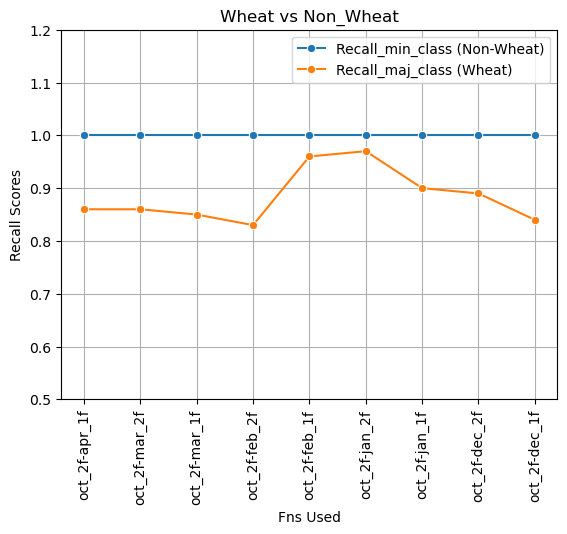

In [14]:
sns.lineplot(y=np.array(test_recall_scores)[:,0], x=fns_used, label='Recall_min_class (Non-Wheat)', marker="o")
sns.lineplot(y=np.array(test_recall_scores)[:,1], x=fns_used, label='Recall_maj_class (Wheat)', marker="o")
plt.xlabel('Fns Used')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Non_Wheat')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

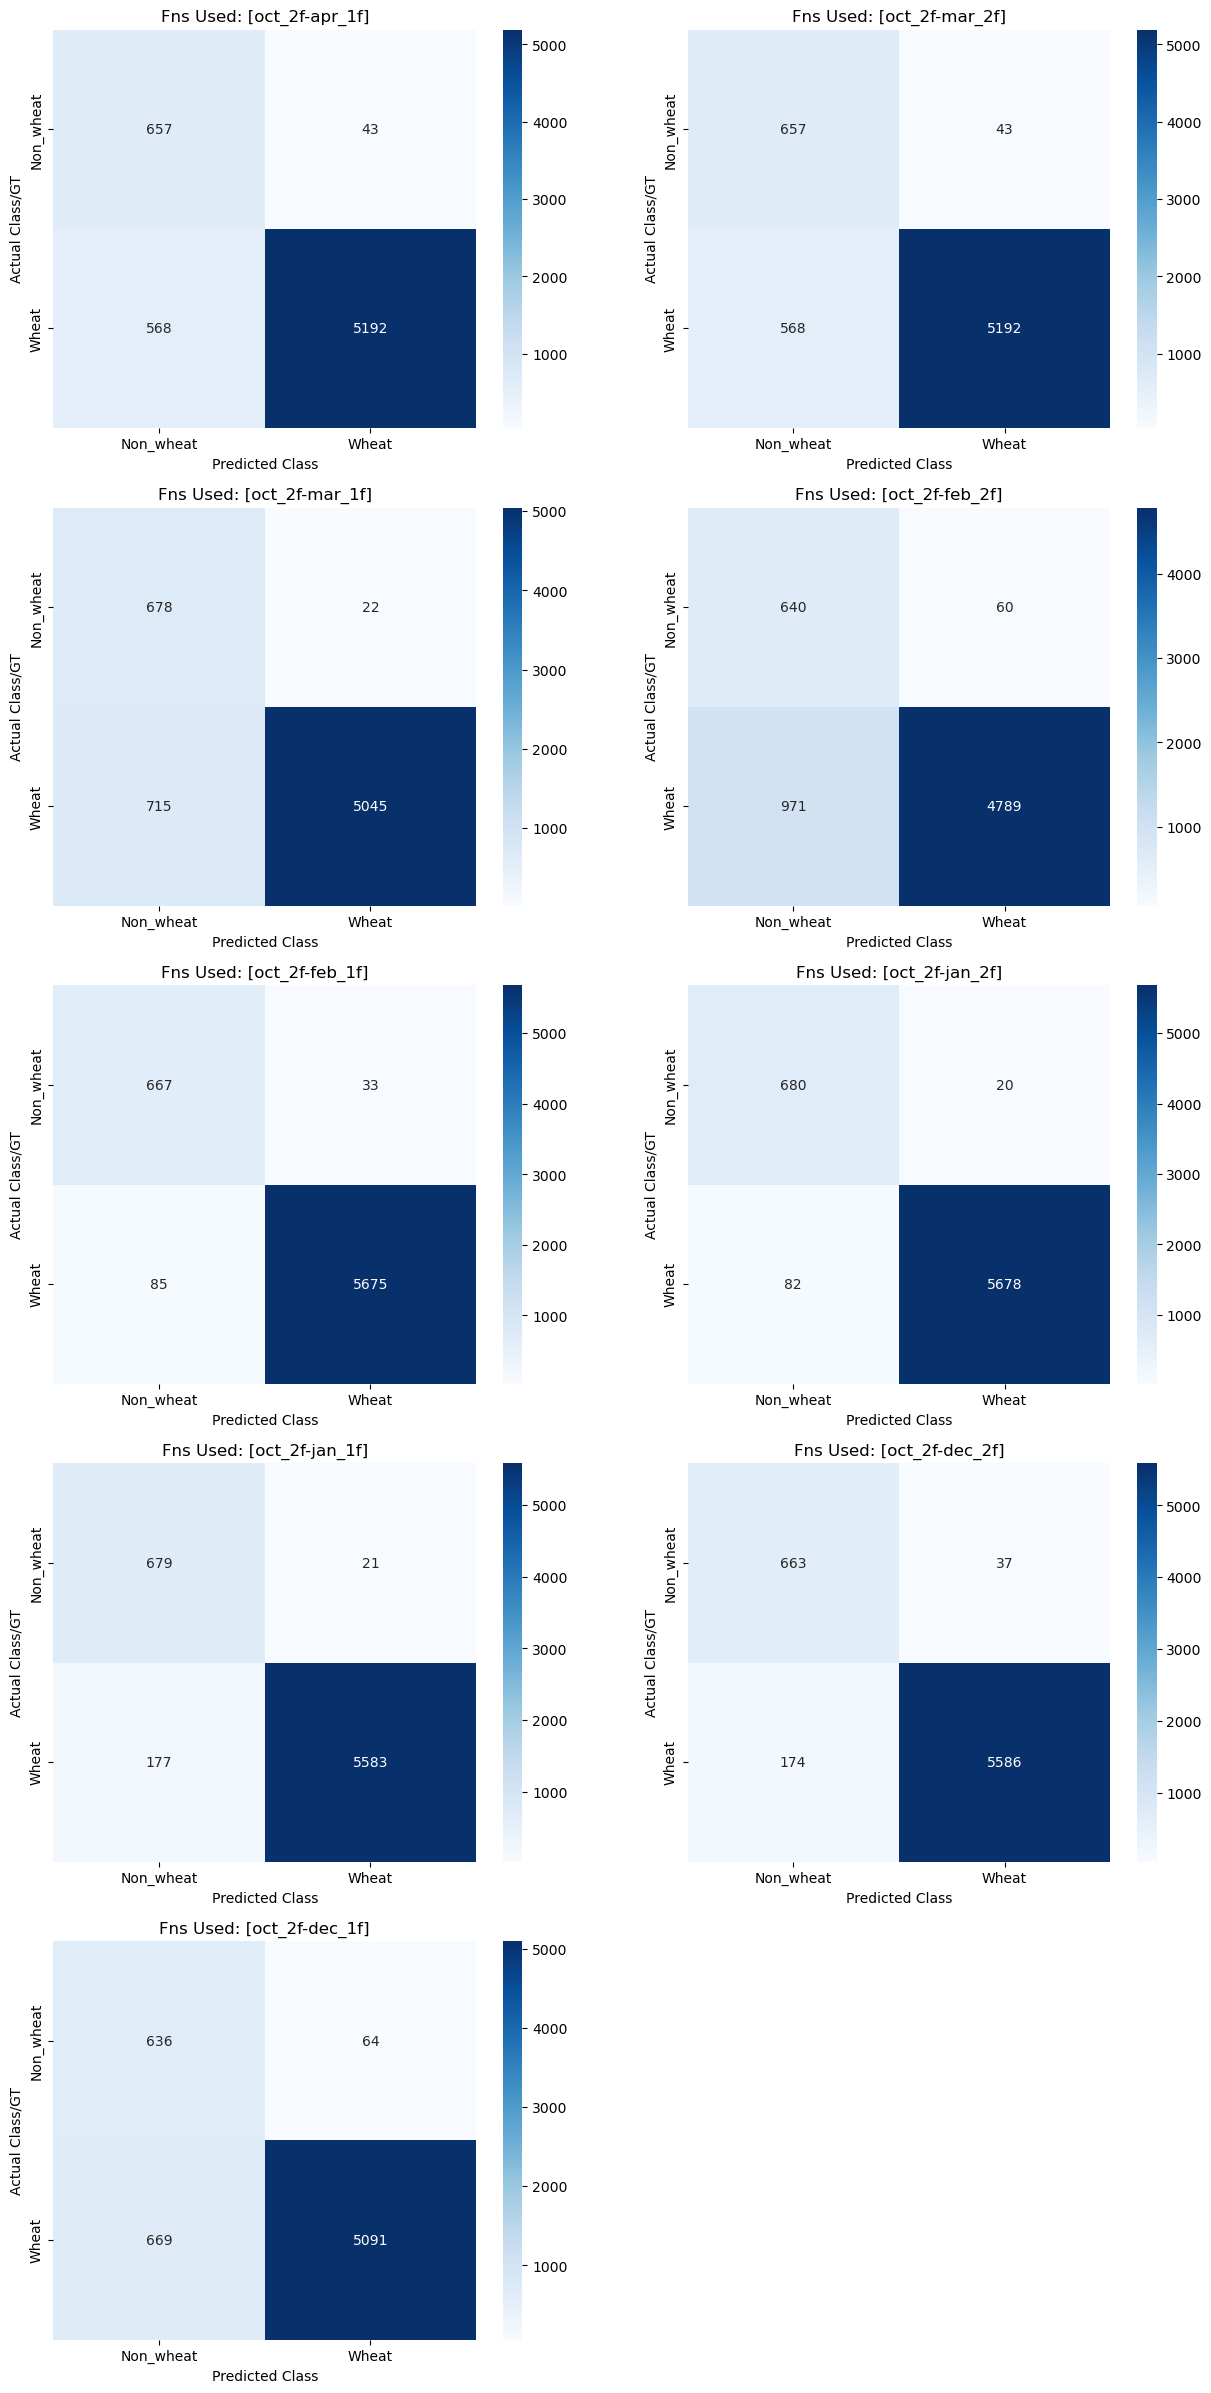

In [10]:
plt.figure(figsize=(15,30))

for i in range(len(confusion_matrices)):
    plt.subplot(5,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Fns Used: [{fns_used[i]}]')
plt.show()

In [11]:
test_dfs

[             GT  correct_pred  correct_pred(%)  incorr_pred_nw  \
 crop_name                                                        
 Non_wheat   700           657            93.86               0   
 Wheat      5760          5192            90.14             568   
 
            incorrect_pred_wh  
 crop_name                     
 Non_wheat                 43  
 Wheat                      0  ,
              GT  correct_pred  correct_pred(%)  incorr_pred_nw  \
 crop_name                                                        
 Non_wheat   700           657            93.86               0   
 Wheat      5760          5192            90.14             568   
 
            incorrect_pred_wh  
 crop_name                     
 Non_wheat                 43  
 Wheat                      0  ,
              GT  correct_pred  correct_pred(%)  incorr_pred_nw  \
 crop_name                                                        
 Non_wheat   700           678            96.86               0   
 